# MRI Brain tumor detection

### Imports

In [51]:
import os
from tempfile import TemporaryDirectory
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay as cmd
from sklearn.metrics import RocCurveDisplay as rcd

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
data_dir = 'images' # path to the images

device: cuda


### Data augmentation and normalization

In [4]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalization values for ImageNet dataset
    ]),
    'val': transforms.Compose([ # avoided data augmentation for validation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalization values for ImageNet dataset
    ]),
}

### Data split and DataLoaders

In [45]:
# This dataset is not split into train and validation sets, must do it manually
full_dataset = datasets.ImageFolder(data_dir, data_transforms['train']) # load all and apply train transforms
train_size = int(0.8 * len(full_dataset)) # 80% of the dataset for training
val_size = len(full_dataset) - train_size # 20% of the dataset for validation
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size]) # split the dataset into train and validation sets
val_dataset.dataset.transform = data_transforms['val'] # apply validation transforms to new validation dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True) # train dataloader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4) # validation dataloader, no need to shuffle

total_size = (len(full_dataset))
train_size = len(train_dataset)
val_size = len(val_dataset)
print(f"Total dataset size: {total_size}")
print(f"Training set size after split: {train_size}")
print(f"Validation set size after split: {val_size}")

Total dataset size: 253
Training set size after split: 202
Validation set size after split: 51


In [11]:
# extract a batch of training images and labels
images, labels = next(iter(train_loader))

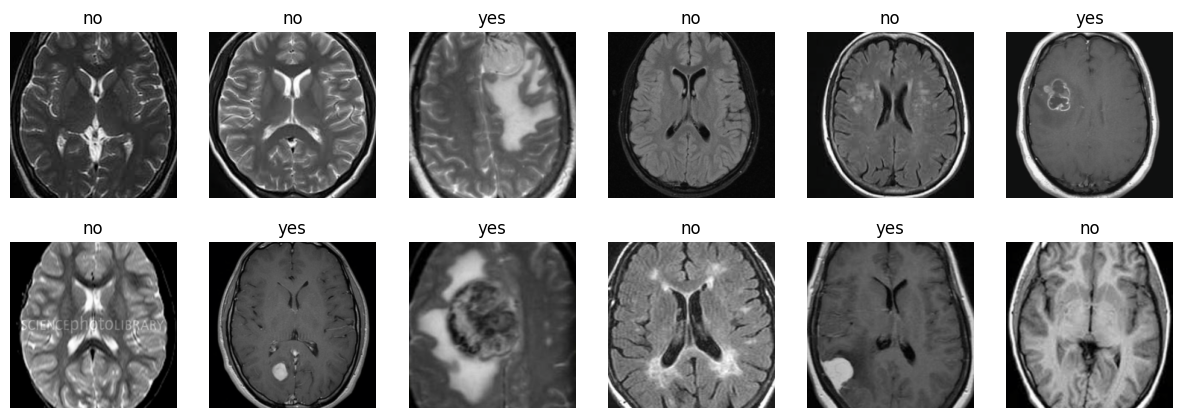

In [42]:
# Simple function to show the first 12 images and their labels
def show_sample_images(image_batch: torch.Tensor, label_batch: torch.Tensor):
    classes = full_dataset.classes
    fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(15, 5))
    axs = axs.flatten()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    for idx in range(12):
        image = image_batch[idx]
        label = label_batch[idx]
        label = label.numpy().item()
        image = image.numpy().transpose((1, 2, 0))
        image = image * std + mean
        image = np.clip(image, 0, 1)
        axs[idx].imshow(image)
        axs[idx].axis('off')
        axs[idx].set_title(classes[label])

show_sample_images(images, labels)

### Model training

In [47]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    start_time = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0


                if phase == 'train':
                    dataloader = train_loader
                    size = train_size
                else:
                    dataloader = val_loader
                    size = val_size
                for inputs, labels in dataloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in the training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / size
                epoch_acc = running_corrects.double() / size

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model if the model training improved the validation accuracy
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # restore the best model parameters
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [48]:
# Download the pre-trained model from torchvision.models
model_ft = models.resnet18(weights='IMAGENET1K_V1')
# get the number of features from the last layer of the pre-trained model
num_ftrs = model_ft.fc.in_features
# modify the fully connected layer to adapt the output size to our number of classes (2)
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device) # Move model to GPU

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\eloim/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:06<00:00, 7.60MB/s]


In [49]:
# start training the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6893 Acc: 0.5941
val Loss: 0.7087 Acc: 0.6667

Epoch 1/24
----------
train Loss: 0.4487 Acc: 0.7871
val Loss: 0.8201 Acc: 0.6667

Epoch 2/24
----------
train Loss: 0.3488 Acc: 0.8465
val Loss: 0.4388 Acc: 0.7451

Epoch 3/24
----------
train Loss: 0.2119 Acc: 0.9257
val Loss: 0.5533 Acc: 0.7451

Epoch 4/24
----------
train Loss: 0.1471 Acc: 0.9356
val Loss: 0.3298 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.0888 Acc: 0.9851
val Loss: 0.2488 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.0574 Acc: 0.9950
val Loss: 0.2545 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.0459 Acc: 1.0000
val Loss: 0.2512 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.0437 Acc: 1.0000
val Loss: 0.2547 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.0387 Acc: 1.0000
val Loss: 0.2517 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.0372 Acc: 1.0000
val Loss: 0.2425 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.0449 Acc: 0.9950
val Loss: 0.2504 Acc: 0.9020

Ep

### Model inference

In [63]:
# function to predict validation dataset
def predict_validation_dataset(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Model is actually placed on GPU, so move predictions to CPU
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels


val_predictions, val_true_labels = predict_validation_dataset(model_ft, val_loader)

print(f"Number of predictions: {len(val_predictions)}")
print(f"Number of true labels: {len(val_true_labels)}")

Number of predictions: 51
Number of true labels: 51


### Model performance

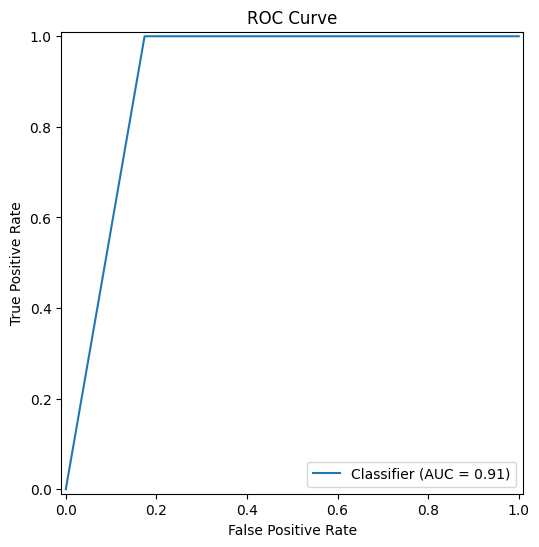

In [60]:
# This is a binary classification problem, so we can use ROC curve to evaluate the model performance
fig, ax = plt.subplots(figsize=(12, 6))
rcd.from_predictions(val_true_labels, val_predictions, ax=ax)
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.show()

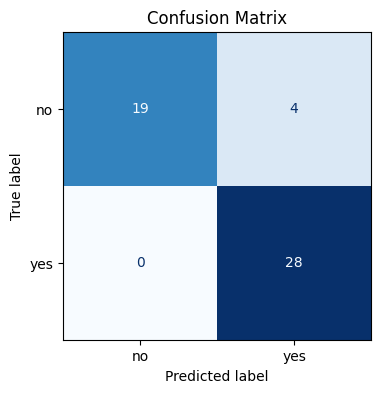

In [59]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
cmd.from_predictions(val_true_labels,
                     val_predictions,
                     ax=ax,
                     display_labels=full_dataset.classes,
                     colorbar=False,
                     cmap='Blues')
ax.set_title('Confusion Matrix')
plt.show()

I don't have a test set, so I will use the validation set (the model hasn't been trained with it).

### Conclusion
* The model tends to overfit (did 100% accuracy on the train set vs. 92% on the validation set). It could be because the model is too complex for the small dataset.
* It is prone to predict false positives, while this is not ideal, in medical cases it is better to have falses positives rather than falses negatives.
* For the positive classes it did perfect, probably because of the overfit, there are more images with the positive class than the negative ones.